<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/featur_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Feature Loss Note Book

In [1]:
from fastai import *
from fastai.vision import*
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
!pip install ipdb 
from ipdb import set_trace as st

In [3]:
pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 14kB/s 
     |████████████████████████████████| 4.0MB 78.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [3]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/medium-256')]

In [4]:
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'medium-256'

In [5]:
path.ls()
!rm -r /root/.fastai/data/oxford-iiit-pet/small-96

In [6]:
x = path_hr.ls()[0]
dest = path_lr/x.relative_to(path_hr)
dest_1 = path_lr/x.name

In [7]:
dest == dest_1

True

In [8]:
def resize(fn, _, path, size):
  dest = path/fn.relative_to(path_hr)
  dest.parent.mkdir(parents = True, exist_ok = True)
  img = PIL.Image.open(fn)
  targ_sz = resize_to(img, size, use_min= True)
  img = img.resize(targ_sz, resample = PIL.Image.BILINEAR).convert('RGB')
  img.save(dest, quality = 60)

In [9]:
sets = [(path_lr, 96), (path_mr, 256)]
il = ImageList.from_folder(path_hr)

In [10]:
resize(il.items[1], 0, path_lr, 96)

In [11]:
path_lr.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/small-96/Egyptian_Mau_164.jpg')]

In [12]:
for p, s in sets:
  print('{} - {}'.format(s, p))
  parallel(partial(resize, path = p, size = s), il.items)

96 - /root/.fastai/data/oxford-iiit-pet/small-96


256 - /root/.fastai/data/oxford-iiit-pet/medium-256


In [13]:
x = path_lr.ls()[0]
img = open_image(x)
img.shape

torch.Size([3, 128, 96])

In [14]:
bs, size = 32, 128
arch = models.resnet34

def get_data(bs, size):
  src = ImageImageList.from_folder(path_lr).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)
  data = src.transform(get_transforms(max_zoom=2.), size= size, tfm_y = True).databunch(bs = bs).normalize(imagenet_stats)
  return data

In [15]:
data = get_data(bs, size)

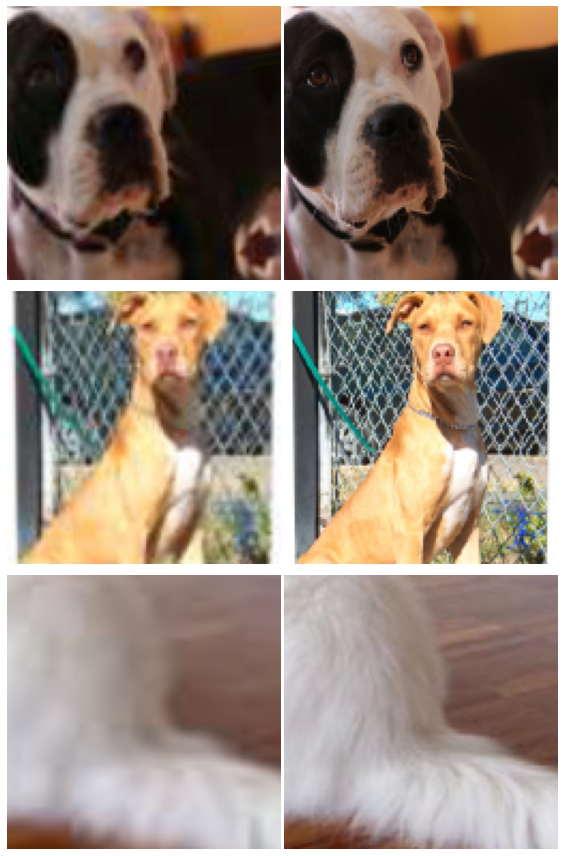

In [16]:
data.show_batch(rows= 3)

In [24]:
t = data.valid_ds[0][1].data
# t.shape
x = torch.stack([t, t])
# x.shape
x = x.view(2, 3, -1)
x.shape
# y = x@x.transpose(1, 2)

torch.Size([2, 3, 16384])

In [33]:
z = x.transpose(1, 2)
z.shape

torch.Size([2, 16384, 3])

In [36]:
y = x@z
y.shape, x.shape, z.shape

(torch.Size([2, 3, 3]), torch.Size([2, 3, 16384]), torch.Size([2, 16384, 3]))

In [39]:
final = y/(3*128*128)
final

tensor([[[0.0644, 0.0739, 0.0597],
         [0.0739, 0.0874, 0.0681],
         [0.0597, 0.0681, 0.0570]],

        [[0.0644, 0.0739, 0.0597],
         [0.0739, 0.0874, 0.0681],
         [0.0597, 0.0681, 0.0570]]])

In [18]:
base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [19]:
vgg_m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [23]:
x =(children(vgg_m))
len(x)
y = []
for i in x:
  if isinstance(i, nn.MaxPool2d):
    y.append(i)

In [27]:
indexes = [i-1 for i, obj in enumerate(children(vgg_m)) if isinstance(obj, nn.MaxPool2d)]
blocks = [children(vgg_m)[i] for i in indexes]

In [28]:
indexes, blocks

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [31]:
vgg_m[4]

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [51]:
"""
Test Feature Loss --- from super_ress note book

class FeatureLoss_C(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        st()
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

fl = FeatureLoss_C(vgg_m, indexes[2:5], [5,15,2])
loss = fl(x, y)
"""

In [72]:
class FeatureLoss(nn.Module):
  def __init__(self, m_feat, layer_ids, layer_wgts):
    super().__init__()
    self.m_feat = m_feat
    self.layer_ids = layer_ids
    self.loss_features = [self.m_feat[i] for i in self.layer_ids]
    self.hooks = hook_outputs(self.loss_features, detach= False)
    self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))]
    self.wgts = layer_wgts
  
  def make_features(self, inp, clone = False):
    self.m_feat(inp)
    return [(o.clone() if clone else o) for o in self.hooks.stored]
  
  def forward(self, input, target):

    out_features = self.make_features(target, clone = True)
    in_features = self.make_features(input)

    self.feat_losses = [base_loss(input, target)]
    self.feat_losses += [base_loss(f_in, f_out) for f_in, f_out, w in zip(in_features, out_features, self.wgts)]

    self.metrics = dict(zip(self.metric_names, self.feat_losses))
    return sum(self.feat_losses)

  def __del__(self):
    self.hooks.remove()

In [56]:
x, y = data.one_batch()
x = x.cuda()
y = y.cuda()
x.shape, y.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 3, 128, 128]))

In [38]:
indexes[2:]

[22, 32, 42]

In [74]:
feat_loss = FeatureLoss(vgg_m, indexes[2:], [1, 2, 3])
# loss = feat_loss(x, y)
# loss

In [75]:
wd = 1e-03
learn = unet_learner(data, models.resnet34, loss_func = feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
# gc.collect()

In [76]:
gc.collect()

114

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


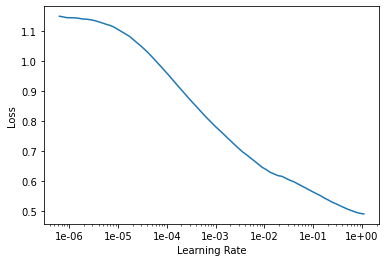

In [77]:
learn.lr_find()
learn.recorder.plot()

In [81]:
def do_fit(name, lrs, pct_start):
  learn.fit_one_cycle(10, lrs, pct_start= pct_start)
  learn.save(name)
  learn.show_results(rows = 3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,time
0,0.272667,0.252093,0.081454,0.047887,0.023215,0.099536,01:03
1,0.180603,0.170969,0.043395,0.034388,0.016693,0.076493,01:01
2,0.160266,0.157266,0.038852,0.031618,0.015299,0.071497,01:01
3,0.155594,0.148820,0.034900,0.030631,0.014718,0.068571,01:01
4,0.152807,0.146434,0.035037,0.029949,0.014368,0.067079,01:01
5,0.147840,0.139690,0.031888,0.029321,0.013965,0.064516,01:01
6,0.142902,0.139750,0.032799,0.029088,0.013880,0.063983,01:01
7,0.141349,0.134458,0.031146,0.028894,0.013538,0.060880,01:01
8,0.138124,0.132516,0.031090,0.028349,0.013299,0.059777,01:01
9,0.134456,0.128249,0.029436,0.027845,0.012995,0.057974,01:01


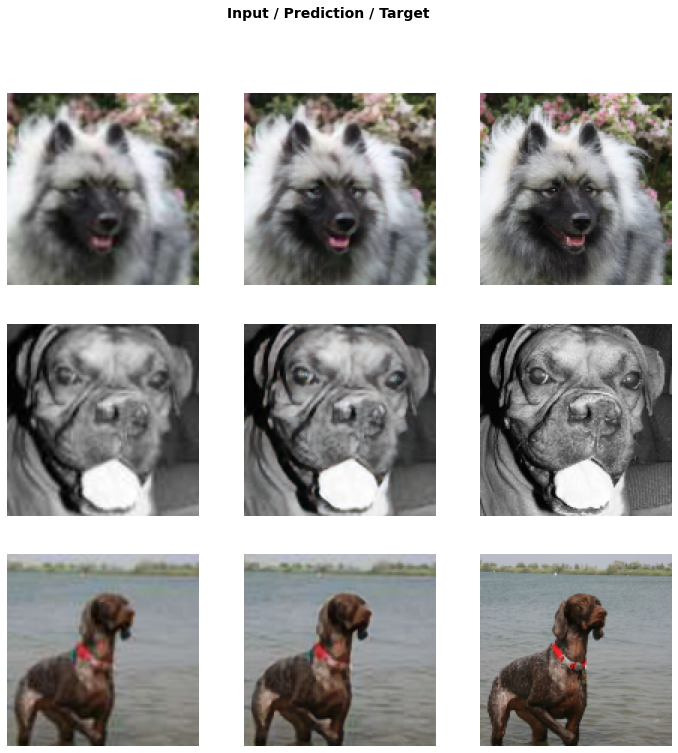

In [82]:
lr = 1e-03
do_fit('stage_1', slice(lr), 0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,time
0,0.133511,0.127703,0.029541,0.027802,0.012928,0.057432,01:04
1,0.132879,0.127588,0.029423,0.027737,0.012926,0.057502,01:04
2,0.132479,0.127322,0.029607,0.027770,0.012907,0.057039,01:04
3,0.132641,0.126609,0.029540,0.027684,0.012825,0.056560,01:04
4,0.132632,0.127160,0.029994,0.027507,0.012811,0.056848,01:04
5,0.132847,0.127148,0.030172,0.027580,0.012781,0.056615,01:04
6,0.131943,0.126087,0.029883,0.027473,0.012708,0.056023,01:04
7,0.132944,0.125927,0.029809,0.027374,0.012686,0.056058,01:04
8,0.130892,0.126878,0.030712,0.027386,0.012691,0.056089,01:04
9,0.127823,0.122281,0.028687,0.026878,0.012376,0.054340,01:04


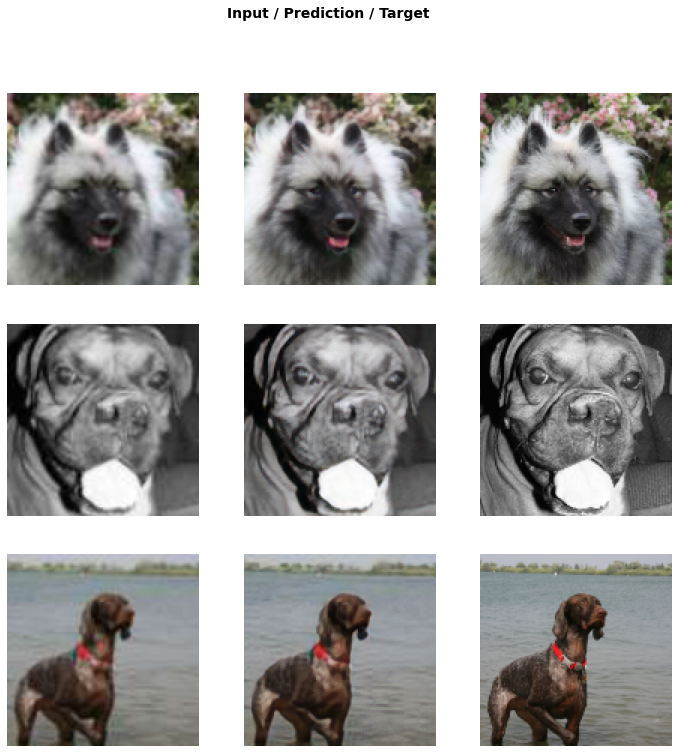

In [83]:
learn.unfreeze()
do_fit('stage-2', slice(1e-05, lr), 0.9)